In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('C:/Users/ACER/Downloads/covid TSAF/india_oringla_daily.csv')

# Filter data for India
india_data = data[data["Country/Region"] == "India"].copy()

# Ensure no missing values
india_data['Confirmed'] = india_data['Confirmed'].fillna(0)

# Calculate daily new confirmed cases
india_data['DailyCases'] = india_data['Confirmed'].diff().fillna(0)

# Add a day counter
india_data['day_count'] = range(1, len(india_data) + 1)

# Filter only meaningful rows (skip initial zeros)
india_data = india_data[india_data['Confirmed'] > 0]

# Display the preprocessed dataset (for verification)
print(india_data.head())


         Date Country/Region  Confirmed  Recovered  Deaths  DailyCases  \
0  13-04-2020          India      10453       1181     358         0.0   
1  14-04-2020          India      11487       1359     393      1034.0   
2  15-04-2020          India      12322       1432     405       835.0   
3  16-04-2020          India      13430       1768     448      1108.0   
4  17-04-2020          India      14352       2041     486       922.0   

   day_count  
0          1  
1          2  
2          3  
3          4  
4          5  


In [6]:
# Define population of India (in 2020)
population = 1380000000

# Prepare data for fitting
xdata = india_data['day_count'].to_numpy()  # Days since first case
ydata = india_data['DailyCases'].to_numpy()  # Daily new cases

# Initial conditions
inf0 = ydata[0]  # Initial number of infected individuals
sus0 = population - inf0  # Initial susceptible population
rec0 = 0  # Initial recovered individuals


1.0294259876667784


C:\Users\ACER\AppData\Local\Temp\ipykernel_26356\2663800242.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["Date"] = pd.to_datetime(data["Date"])


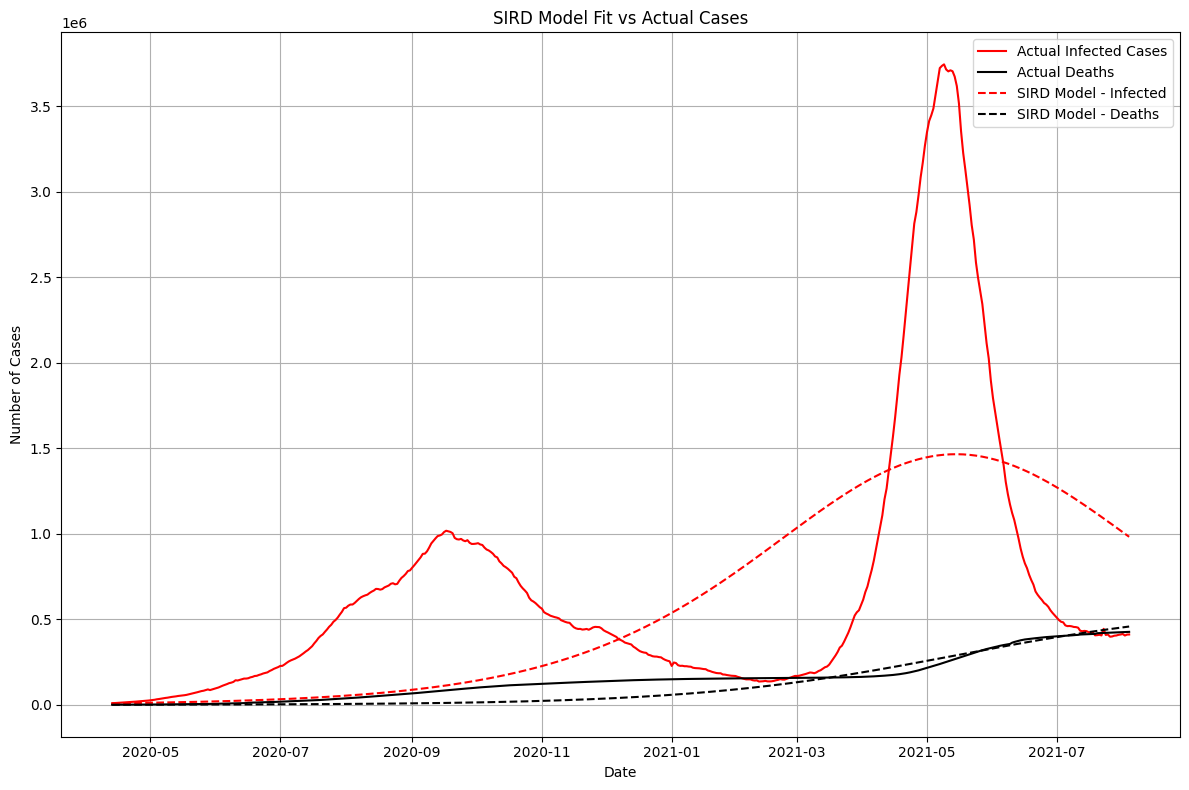

Optimal beta: 0.3587
Optimal gamma (recovery rate): 0.3408
Optimal mu (mortality rate): 0.0016


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# Load the dataset
data = pd.read_csv('C:/Users/ACER/Downloads/covid TSAF/india_oringla_daily.csv')

# Preprocess data
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date")
infected = data["Confirmed"] - data["Recovered"] - data["Deaths"]
recovered = data["Recovered"]
deaths = data["Deaths"]

# Population size (replace with actual region's population if available)
N = 1380000000  # Replace with actual population
I0 = infected.iloc[0]  # Initial number of infected
R0 = recovered.iloc[0]  # Initial number of recovered
D0 = deaths.iloc[0]  # Initial number of deaths
S0 = N - I0 - R0 - D0  # Initial number of susceptible
t = np.arange(len(data))  # Time in days

# Define the SIRD model
def sird_model(y, t, beta, gamma, mu):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dIdt, dRdt, dDdt]

# Solve the SIRD equations
def solve_sird(beta, gamma, mu):
    return odeint(sird_model, [S0, I0, R0, D0], t, args=(beta, gamma, mu))

# Loss function to optimize
def loss_function(params):
    beta, gamma, mu = params
    solution = solve_sird(beta, gamma, mu)
    _, I_model, _, D_model = solution.T
    # Weighted error between model and actual data for infected and deaths
    return np.mean((I_model - infected)**2) + np.mean((D_model - deaths)**2)

# Optimize parameters
initial_guess = [0.4, 0.1, 0.01]  # Initial guesses for beta, gamma, mu
bounds = [(0, 1), (0, 1), (0, 1)]  # Parameter bounds
result = minimize(loss_function, initial_guess, bounds=bounds)
beta_opt, gamma_opt, mu_opt = result.x

# Solve with optimal parameters
sird_solution = solve_sird(beta_opt, gamma_opt, mu_opt)
S_fit, I_fit, R_fit, D_fit = sird_solution.T

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(data["Date"], infected, "r", label="Actual Infected Cases")
plt.plot(data["Date"], deaths, "k", label="Actual Deaths")
plt.plot(data["Date"], I_fit, "r--", label="SIRD Model - Infected")
plt.plot(data["Date"], D_fit, "k--", label="SIRD Model - Deaths")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("SIRD Model Fit vs Actual Cases")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print parameters
print(f"Optimal beta: {beta_opt:.4f}")
print(f"Optimal gamma (recovery rate): {gamma_opt:.4f}")
print(f"Optimal mu (mortality rate): {mu_opt:.4f}")


In [7]:
# Define the SIR model differential equations
def sir_model(y, x, beta, gamma):
    S, I, R = y
    dS = -beta * S * I / population
    dI = beta * S * I / population - gamma * I
    dR = gamma * I
    return [dS, dI, dR]
